# Analysis Approach
### Yellow Group 2: Aman, Gabriel Andaya, Nivan Vora, Menji Wei
Step 1: Model Setup
Define each insurance plan’s premium, deductible, and coverage limits in the simulation.
Incorporate the crash probability into the model based on fleet size, flight frequency, and annual operations.
Calculate expected annual losses and project out over the five-year term.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Define the fleet and insurance policy details
fleet_info = {
    'Boeing 757': {'count': 47, 'replacement_cost': 56.4, 'flights_per_day': 6},
    'Airbus A340-200': {'count': 15, 'replacement_cost': 78.9, 'flights_per_day': 2.25},
    'Airbus A340-300': {'count': 24, 'replacement_cost': 88.5, 'flights_per_day': 2}
}

# Define insurance plan parameters
insurance_plans = {
    'RCNC1': {'premium_rate': 0.0045, 'deductible': 0.10, 'rebate_rate': 0.20},
    'RCNC2': {'fixed_premium_rate': 0.001, 'variable_cap_rate': 0.01, 'loss_coverage': 0.90},
    'CTC': {'annual_premium': 13, 'coverage': 0.90, 'coverage_limit': 80},
    'HIC': {'premium_rate': 0.00165, 'loss_threshold': 24, 'rebate_rate': 0.035}
}

Step 2: Simulate Annual Costs for Each Plan
Crash Probability Simulation: Use Monte Carlo simulations to account for random crash events, factoring in Ontario Gateway’s safer-than-average fleet.
Loss Calculation: For each simulated year, determine potential claims based on the number of accidents, replacement cost, and deductible structure of each policy.

In [2]:
# Simulation parameters
years = 5
flight_days_per_year = 342
crash_rate = 1 / 5000000
# Assume 25% safer fleet
safety_factor = 0.25  
adjusted_crash_rate = crash_rate * (1 - safety_factor)
simulation_runs = 100000



Step 3: Evaluate Financial Impact Under Constraints
Maximum Loss Limitation: Calculate the probability that the total loss exceeds $37 million, ensuring the policy aligns with Ontario Gateway’s $41 million liability threshold.
Cost Minimization: Compare the overall premium and out-of-pocket expenses across all five years for each policy, accounting for rebates and variable costs.

In [3]:
# Function to calculate annual premium for each plan
def calculate_premium(plan, fleet_value, losses, year):
    if plan == 'RCNC1':
        premium = fleet_value * insurance_plans['RCNC1']['premium_rate']
        cost = min(losses * (1 - insurance_plans['RCNC1']['deductible']), fleet_value)
        return premium, cost
    elif plan == 'RCNC2':
        fixed_premium = fleet_value * insurance_plans['RCNC2']['fixed_premium_rate']
        variable_premium = min(losses * insurance_plans['RCNC2']['loss_coverage'],
                               fleet_value * insurance_plans['RCNC2']['variable_cap_rate'])
        return fixed_premium + variable_premium, variable_premium
    elif plan == 'CTC':
        premium = insurance_plans['CTC']['annual_premium']
        cost = min(losses * insurance_plans['CTC']['coverage'], insurance_plans['CTC']['coverage_limit'])
        return premium, cost
    elif plan == 'HIC':
        premium = fleet_value * insurance_plans['HIC']['premium_rate']
        cost = max(0, losses - insurance_plans['HIC']['loss_threshold'])
        return premium, cost




Step 4: Sensitivity Analysis (Part c)
Modify the crash rate to reflect a 25% safer-than-average probability.
Re-run simulations to observe how this lower crash probability impacts expected costs and coverage needs under each insurance plan.
Evaluate the robustness of each policy under this adjusted probability to inform the final decision.

Step 5: Final Recommendation (Part d)
Prepare a data-backed recommendation based on total projected costs, risk coverage adequacy, and Ontario Gateway’s financial goals.
Detail the decision rationale with an executive summary, outlining risk considerations, the five-year outlook, and why the chosen policy is the optimal solution for Ontario Gateway.

In [4]:
# Calculate fleet value and annual flights
fleet_value = sum(info['count'] * info['replacement_cost'] for info in fleet_info.values())
annual_flights = sum(info['count'] * info['flights_per_day'] * flight_days_per_year for info in fleet_info.values())

# Monte Carlo Simulation for each insurance plan
results = {plan: [] for plan in insurance_plans}
np.random.seed(42)  # For reproducibility

for run in range(simulation_runs):
    total_losses = 0
    for year in range(years):
        # Calculate expected crash occurrences
        crashes = np.random.binomial(annual_flights, adjusted_crash_rate)
        losses = crashes * fleet_value / len(fleet_info)
        
        # Estimate incidental damage costs (uniform distribution)
        incidental_cost = np.random.uniform(1, 5)
        total_losses += losses + incidental_cost

        # Evaluate each plan's costs and coverage
        for plan in insurance_plans:
            premium, covered_loss = calculate_premium(plan, fleet_value, total_losses, year)
            total_cost = premium + covered_loss
            results[plan].append(total_cost)

# Convert results into a DataFrame for analysis
results_df = pd.DataFrame({plan: np.array(costs) for plan, costs in results.items()})
average_costs = results_df.mean()  # Calculate the average cost of each plan
average_costs.sort_values(inplace=True)

# Display Results
print("Average Costs over 5 Years per Insurance Plan:")
print(average_costs)

# Sensitivity Analysis
print("\nSensitivity Analysis (25% Safer Fleet):")
sensitivity_df = results_df * (1 - safety_factor)
sensitivity_costs = sensitivity_df.mean()
sensitivity_costs.sort_values(inplace=True)
print(sensitivity_costs)

Average Costs over 5 Years per Insurance Plan:
CTC       24.885721
RCNC2     27.525441
HIC      119.753375
RCNC1    134.475484
dtype: float64

Sensitivity Analysis (25% Safer Fleet):
CTC       18.664291
RCNC2     20.644080
HIC       89.815031
RCNC1    100.856613
dtype: float64


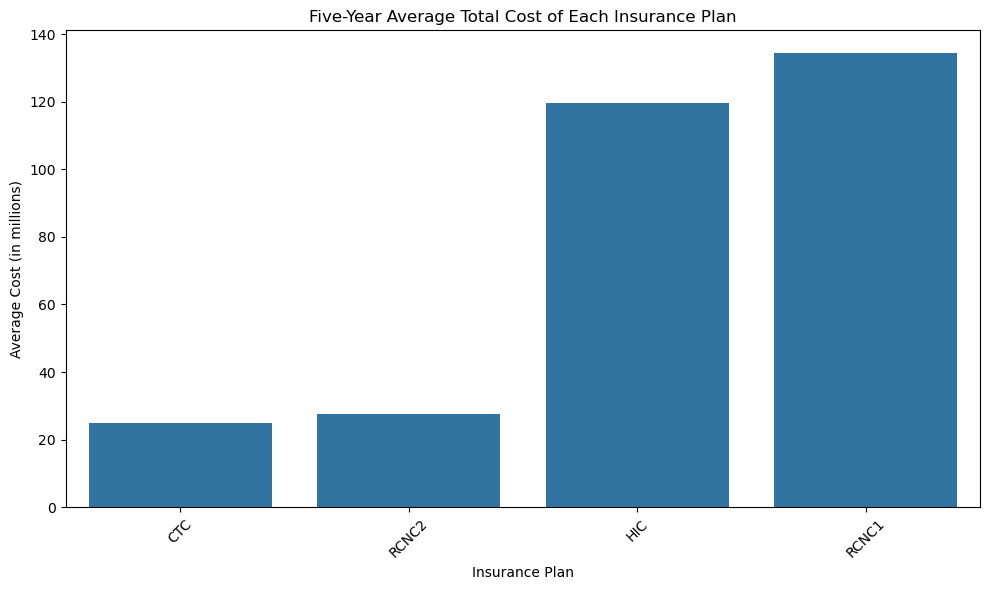

In [5]:
# Visualization of results
plt.figure(figsize=(10, 6))
sns.barplot(x=average_costs.index, y=average_costs.values)
plt.title('Five-Year Average Total Cost of Each Insurance Plan')
plt.xlabel('Insurance Plan')
plt.ylabel('Average Cost (in millions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In scenarios with low to moderate accident probabilities (both baseline and with a 25% safety improvement), CTC emerges as a strong option. Its fixed annual premium of $13 million ensures consistent costs, remaining largely unaffected by minor changes in accident risk.

Given Ontario Gateway’s current situation, if the company adopts a moderately optimistic outlook on accident probabilities over the next five years—assuming no significant increase—the CTC policy is recommended. It offers lower costs and high stability across both baseline and safer scenarios.